In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from pathlib import Path
import cv2
import tqdm


import sys
sys.path.append("../src")

import util

import pandas as pd
import numpy as np
import ast

In [3]:
model_folder = Path("../output/0104_yolov5s_fold0/")
params_path = model_folder / "config" / "params.pkl"
params = util.load_pickle(params_path)
params

In [4]:
home_dir = Path("/home/vincent/Kaggle/Kaggle_TGBR/output/")
data_dir = Path("/home/vincent/Kaggle/data/tensorflow-great-barrier-reef")
def transform_params(params, home_dir, data_dir):
    for key, val in params.items():
        if "path" in key or "dir" in key:
            old_val = val.resolve()
            if key not in ["data_path", "root_dir"]:
                new_val = home_dir / "/".join(str(old_val).split("/")[6:])
            else:
                new_val = data_dir
            params[key] = new_val
    return params

In [5]:
params = transform_params(params, home_dir, data_dir)

In [8]:
params["repo"] = "./yolov5"
params["run_test"] = False

In [13]:
df = pd.read_csv(params["root_dir"] / 'train.csv')
df = df.apply(lambda x: util.get_path(x, params, infer=True), axis=1)
df['annotations'] = df['annotations'].apply(lambda x: ast.literal_eval(x))
df['num_bbox'] = df['annotations'].apply(lambda x: len(x))
util.seed_torch(params["seed"])    
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255)) for idx in range(1)]    

YOLOv5 🚀 v6.0-163-gd95978a torch 1.10.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2080 Ti, 11016MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


predict training data
/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train_images/video_1/4258.jpg


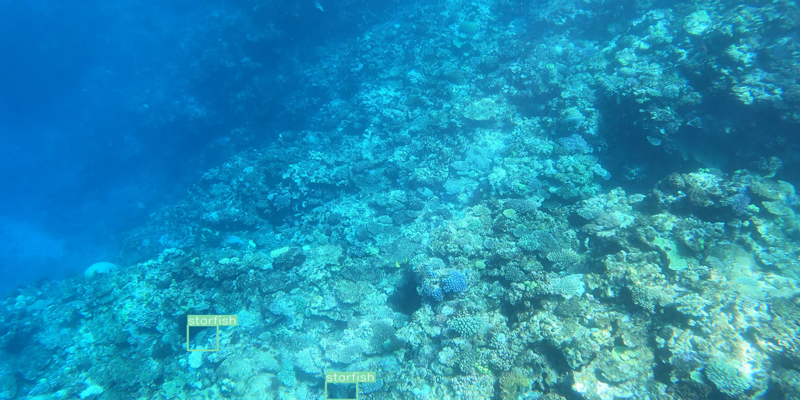

/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train_images/video_1/5419.jpg


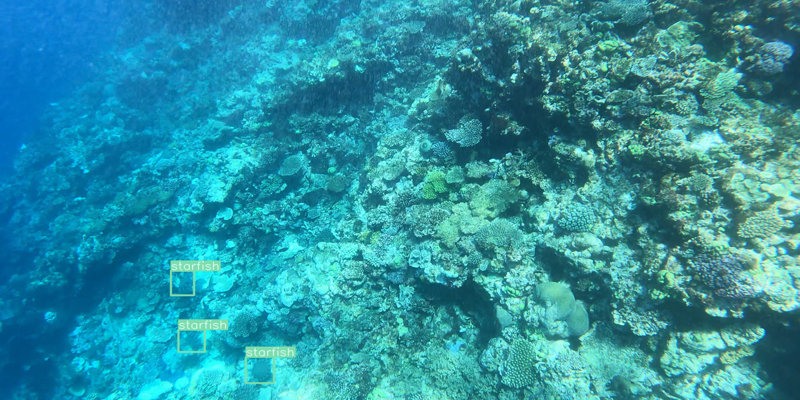

/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train_images/video_0/8936.jpg


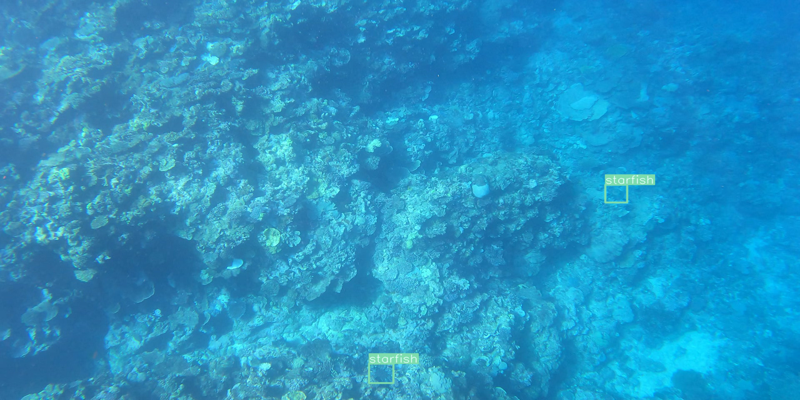

/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train_images/video_1/3908.jpg


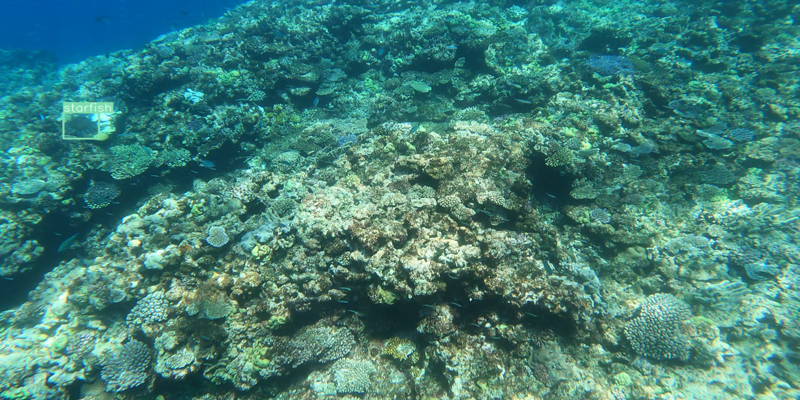

/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train_images/video_1/4221.jpg


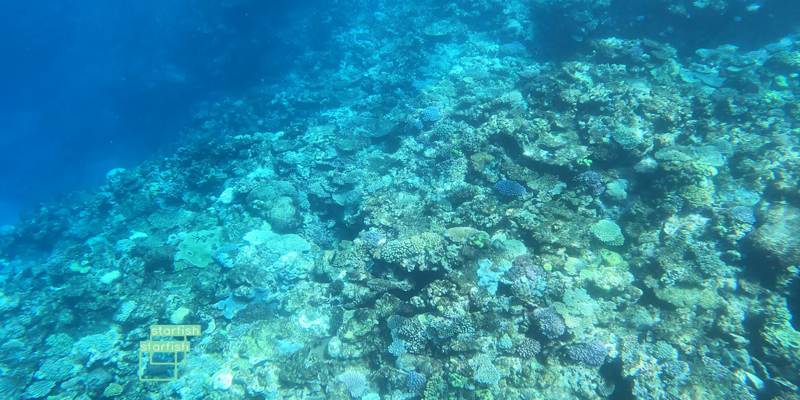

/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train_images/video_1/5858.jpg


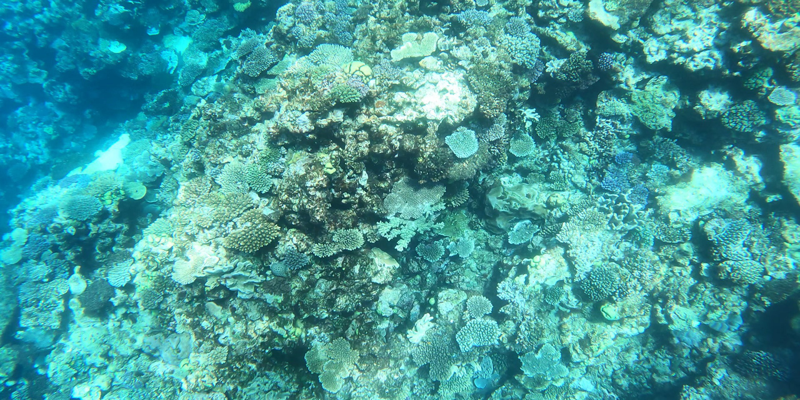

/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/train_images/video_1/8876.jpg


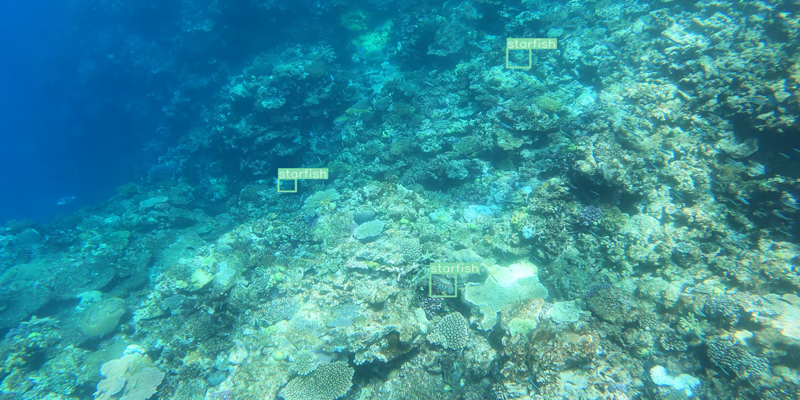

In [14]:
model = util.load_model(params)
print("predict training data")
image_paths = df[df.num_bbox>1].sample(100).image_path.tolist()    
for idx, path in enumerate(image_paths):
    print(path)
    img = cv2.imread(str(path))[...,::-1]
    bboxes, confis = util.predict(model, img, size=params["img_size"], augment=params["augment"])
    display(util.show_img(img, bboxes, colors, bbox_format='coco'))
    if idx>5:
        break

In [15]:
if params["run_test"]:
    print("Run test")
    import greatbarrierreef
    env = greatbarrierreef.make_env()# initialize the environment
    iter_test = env.iter_test()      # an iterator which loops over the test set and sample submission
    model = util.load_model(params)
    for idx, (img, pred_df) in enumerate(tqdm(iter_test)):
        bboxes, confs = util.predict(model, img, size=params["img_size"], augment=params["augment"])
        annot = util.format_prediction(bboxes, confs)
        pred_df['annotations'] = annot
        env.predict(pred_df)
        if idx<3:
            display(util.show_img(img, bboxes, colors, bbox_format='coco'))
    sub_df = pd.read_csv('submission.csv')
    print(sub_df.head())